# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model


In [1]:
import condensate_speckle
from condensate_speckle.data_io import get_example_data_file_path, load_data
from condensate_speckle.inference.model import set_model

# General model & simulating data

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=\sum_{i=1}^{p}\phi_i\times Y_{t-i}+e_t$, where $Y$ is the intensity at each time point, $\phi_i$ is the decay parameter that depends on $\tau$, and $e_t$ is the innovation term. For this project, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=\phi\times Y_{t-1}+e_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=\exp(-1/\tau)\times Y_{t-1}+e_t$. 

We need to specify three variables in order to build the generative model: the mean $c$ and standard deviation $\sigma_e$ of the innovation term $e_t$, and decay time $\tau$. Here, $e_t$ is considered as Gaussian distribution and $\tau$ is the value that we are most interested in. We also need the distribution noise level of microscope, which is assumed to be a Normal distribution as well.

From the model, the overall data intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az
import statsmodels.api as sm
import csv

/Users/Hanyue/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
X = load_data('[110, 145]_intensity.csv',data_dir='condensate_speckle/example_data').to_numpy()

/Users/Hanyue/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[110, 145]_intensity.csv


In [14]:
data_pds={'t':X[0],'Intensity':X[1]}

In [5]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Fitting simulated data with pymc3 AR(1) model

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [16]:
quantization = 255
ar1_model=set_model(data_pds['Intensity'],quantization)

In [7]:
estimate = pm.find_MAP(model = ar1_model)

In [8]:
estimate

{'decay_time_interval__': array(13.16219756),
 'precision_interval__': array(82.29843443),
 'noise_std_interval__': array(-3.07031895),
 'y': array([ 7.67466394e+00,  7.85149286e+00,  8.17734199e+00,  8.51159586e+00,
         8.84450159e+00,  9.18859657e+00,  9.51622568e+00,  9.62790970e+00,
         9.62014731e+00,  9.51026202e+00,  9.28577181e+00,  9.06816131e+00,
         8.79878358e+00,  8.43669168e+00,  8.04874408e+00,  7.62392101e+00,
         7.10839875e+00,  6.37474018e+00,  5.64526273e+00,  5.04700576e+00,
         4.59920853e+00,  3.82814419e+00,  3.05543762e+00,  2.33847258e+00,
         1.64202130e+00,  9.53838273e-01,  4.58089108e-01, -2.12626685e-02,
        -4.95601461e-01, -8.34626152e-01, -1.09882364e+00, -1.49385837e+00,
        -2.01505329e+00, -2.49034058e+00, -2.85227536e+00, -3.11911940e+00,
        -3.27267857e+00, -3.44148300e+00, -3.53927269e+00, -3.70053908e+00,
        -3.86148446e+00, -3.90583061e+00, -3.81248913e+00, -3.78840388e+00,
        -3.76572856e+00

In [9]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/7g/r91p7_3s5ms7npzg4qybv9680000gn/T/ipykernel_7234/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 199400
Interrupted at 199,399 [99%]: Average Loss = 3,770.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, noise_std, precision, decay_time]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [10]:
# A probabilistic generator for tao
tao = 10
phi = np.exp(-1/tao)

camera_noise_mean = 5
camera_noise_std = 1

intensity_mean = 80
intensity_std = 20

# A probabilistic generator for the innovation term.
innovation_mean = intensity_mean*(1-phi) # this is the mean of innovation
innovation_std = intensity_std*np.sqrt(1-phi**2) # this is the standard deviation of the innovation 

intensity_variance = intensity_std**2 # this is the expectation value of all intensity signals

/Users/Hanyue/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


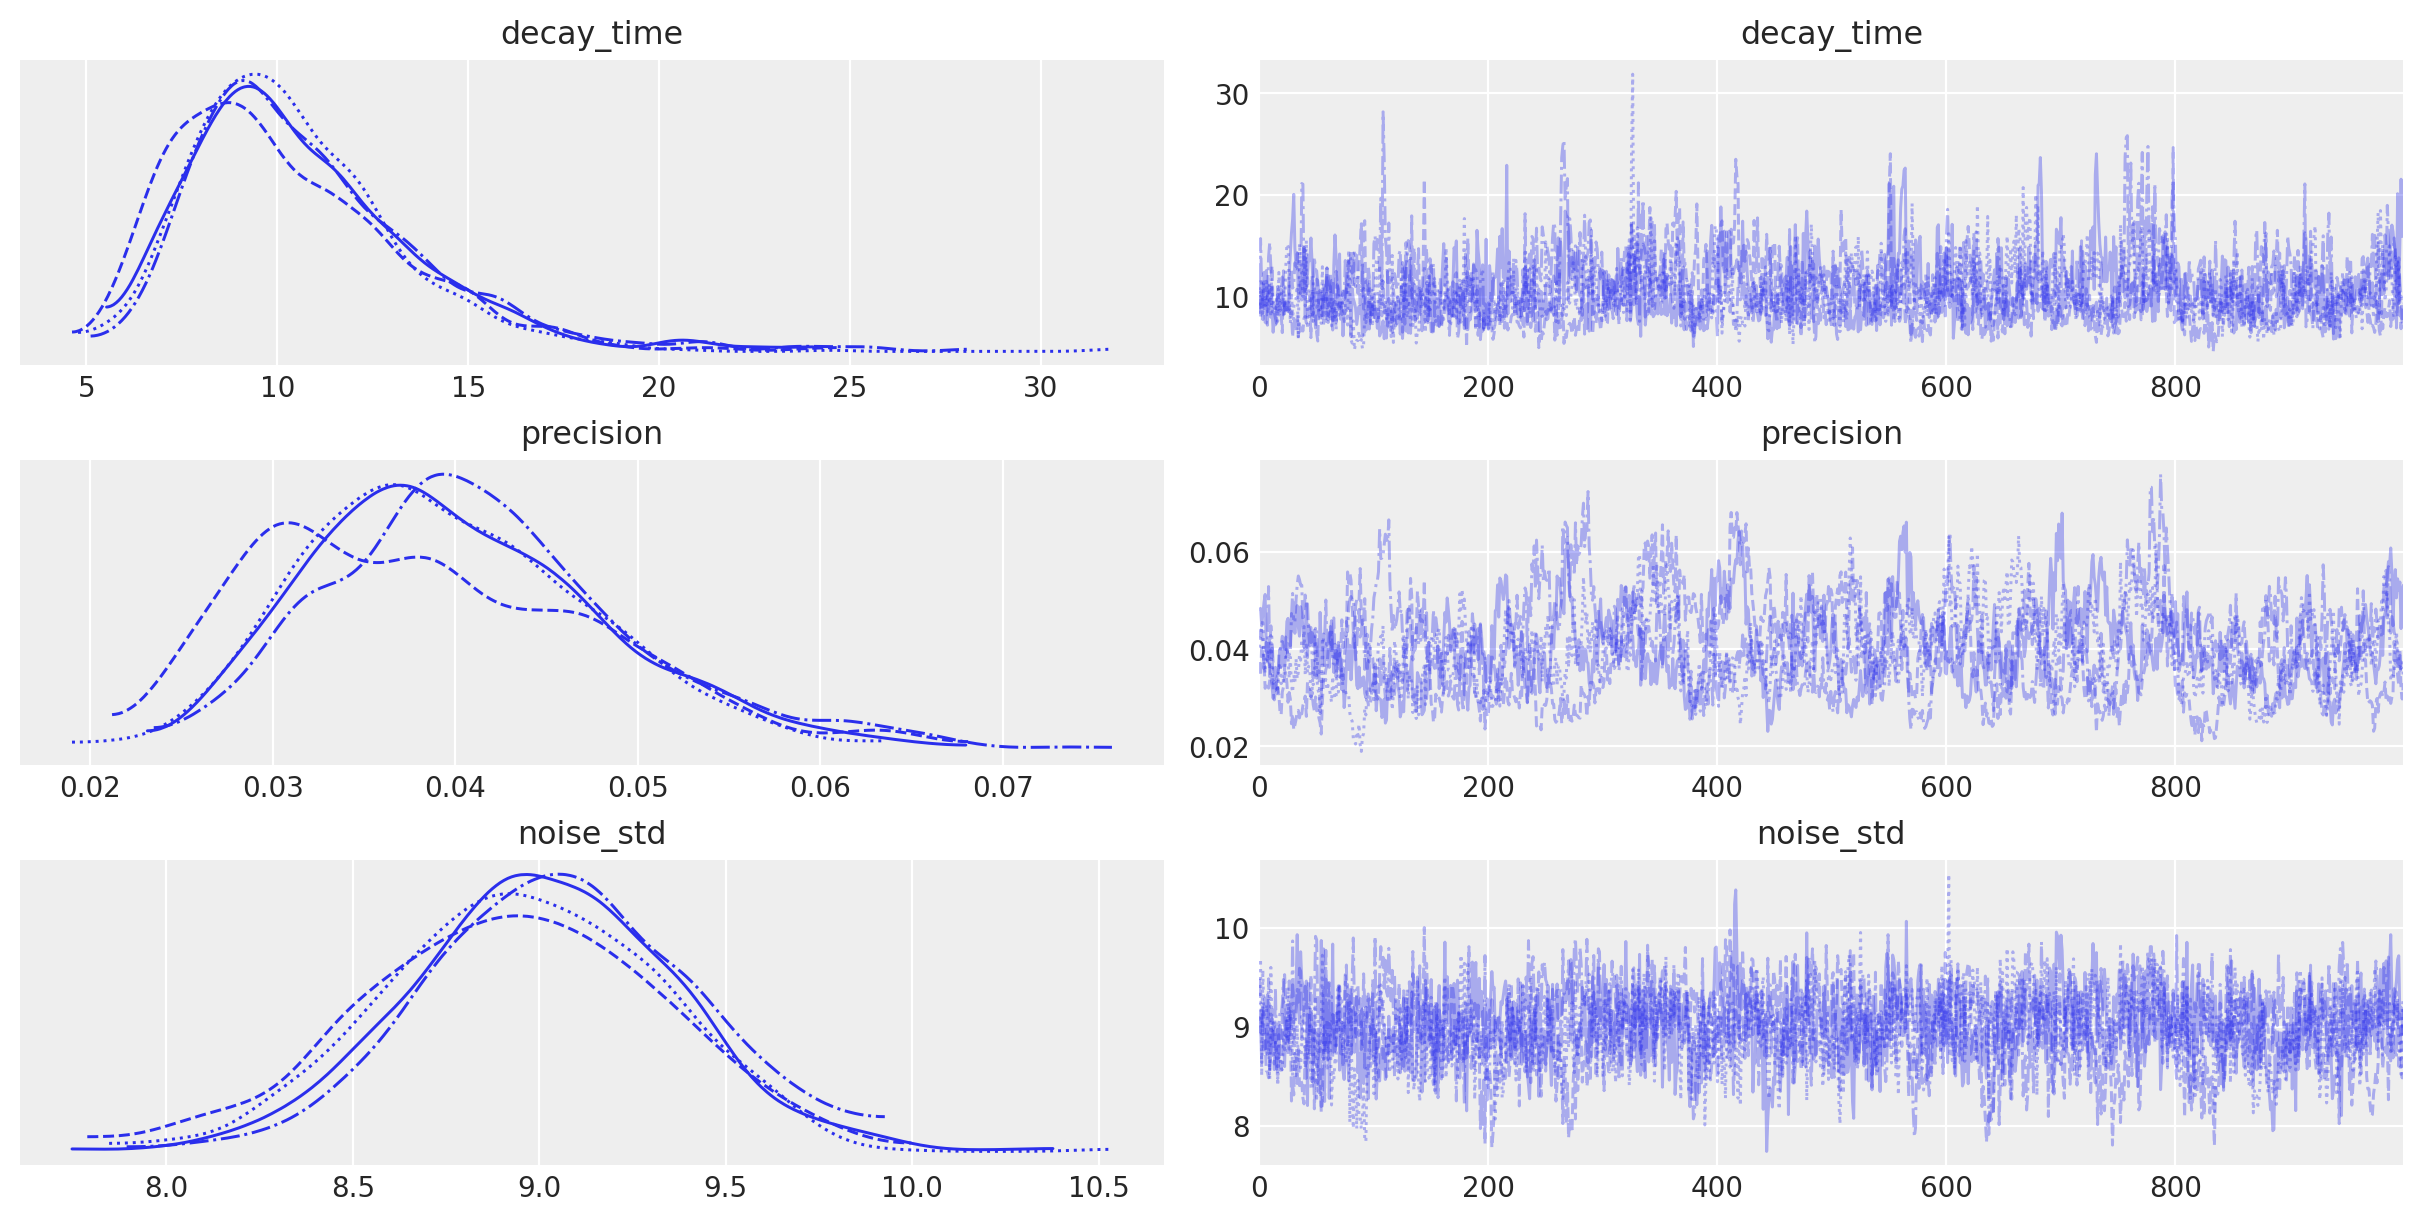

In [13]:
az.plot_trace(
    trace,
    var_names = ['decay_time','precision','noise_std'],
);

About the camera noise, we tried to calculate our overall uncertainty as $\tau_E=\frac{1}{\frac{1}{precisionAR1}+(1-k^2)\sigma_{CameraNoise}^2}$, where $k=e^{-1/\tau}$, $precisonAR1=\frac{1}{\sigma_{e}^2}$. But it is still very far from true values. We will come to office hour for help. :)